# 循环神经网络

In [1]:
import torch
import math
import My_utils
from torch import nn
import torch.nn.functional as F

In [2]:
batch_size, num_steps = 32, 35
train_iter, vocab = My_utils.load_data_time_machine(batch_size, num_steps)

## 初始化模型参数

In [3]:
def get_params(vocab_size, num_hiddens, device):
    # 输入和输出采用相同的词表，vocab_size是使用的词表的大小
    # 所以这实际上是一个多分类的问题
    num_inputs = num_outputs = vocab_size
    
    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01    
    
    w_xh = normal((num_inputs, num_hiddens))
    w_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    w_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    params = [w_xh, w_hh, b_h, w_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [4]:
# 在初始化时返回隐藏层状态
# 由于后续的rnn的隐状态包含多个变量，因此使用返回元组更方便
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

In [5]:
def rnn(inputs, state, params):
    w_xh, w_hh, b_h, w_hq, b_q = params
    h, = state
    outputs = []
    for x in inputs:
        h = torch.tanh(torch.mm(x, w_xh) + torch.mm(h, w_hh)+ b_h)  # h: batch_size * num_hiddens
        y = torch.mm(h, w_hq) + b_q
        outputs.append(y)
    # outputs是一个存tensor的list
    return torch.cat(outputs, dim=0), (h,)

In [6]:
class RNNModelScratch:
    def __init__(self, vocab_size, num_hiddens, device, get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)  # 用于初始化模型参数
        self.init_state, self.forward_fn = init_state, forward_fn
    
    def __call__(self, x, state):  # x: batch_size * num_steps  
        x = F.one_hot(x.T, self.vocab_size).type(torch.float32)  # (35, 32, 28)
        return self.forward_fn(x, state, self.params)
    
    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

x取转置的原因：
时间步优先处理：这符合RNN处理序列数据的方式，即一次处理一个时间步，同时考虑所有样本的该时间步。这种处理方式允许模型维护和更新其隐藏状态，以反映到目前为止观察到的序列信息。
批处理优化：对于每个时间步，模型可以利用矩阵运算对批次中的所有样本同时进行计算。这是深度学习中常用的优化手段，可以显著提高计算效率。
兼容性：某些深度学习框架和库（例如PyTorch和TensorFlow）在设计时就考虑了这种数据布局（即时间步在前，批次索引在后），因此转置输入数据可以确保与这些框架的预期输入格式兼容。

In [7]:
num_hiddens = 512
x = torch.arange(10).reshape((2, 5))
net = RNNModelScratch(len(vocab), num_hiddens, My_utils.try_gpu(), get_params, init_rnn_state, rnn)
state = net.begin_state(x.shape[0], My_utils.try_gpu())
y, new_state = net(x.to(My_utils.try_gpu()), state)
y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

In [8]:
def predict_ch8(prefix, num_preds, net, vocab, device):
    # 生成prefix之后的字符
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]  # text -> num
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    # 将prefix读入outputs中
    for y in prefix[1: ]:
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])     

In [9]:
predict_ch8('time traveller', 10, net, vocab, device=My_utils.try_gpu())

'time travellerrr <unk>z<unk>z<unk>z<unk>'

## 梯度裁剪
$$\mathbf{g} \leftarrow \min\left(1, \frac{\theta}{\|\mathbf{g}\|}\right) \mathbf{g}.$$

In [10]:
def grad_clipping(net, theta):
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

## 训练

In [14]:
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    state, timer = None, My_utils.Timer()
    metric = My_utils.Accumulator(2)  # 训练损失之和，词语元数量
    for x,y in train_iter:
        if state is None or use_random_iter:  # use_random_iter说明seq不连续
            state = net.begin_state(batch_size=x.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                state.detach_()
            else:
                for s in state:
                    s.detach_()
        y = y.T.reshape(-1)  # y.T: num_steps * batch_size
        x, y = x.to(device), y.to(device)
        y_hat, state = net(x, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [12]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device, use_random_iter=False):
    loss = nn.CrossEntropyLoss()
    animator = My_utils.Animator(xlabel='epoch', ylabel='perplexity', legend=['train'], xlim=[10, num_epochs])
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr=lr)
    else:
        updater = lambda batch_size: My_utils.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'perplexity: {ppl:.1f}, speed: {speed:.1f} words/sec on {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

perplexity: 1.4, speed: 101532.6 words/sec on cuda:0
time traveller after the pauserequired for the proper assimilati
traveller after the pauserequired for the proper assimilati


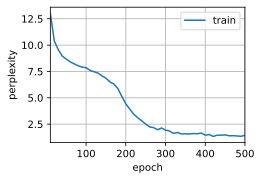

In [15]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, device=My_utils.try_gpu())